# NFL Big Data Bowl 2026 - Team-Specific Scouting Reports

**Goal:** Create weekly opponent scouting reports that identify:
1. **Team Defensive Weaknesses** - Which defenders to attack
2. **Coverage Vulnerabilities** - Best route types vs their coverages
3. **Formation Exploits** - What formations create problems for them
4. **Tempo Vulnerabilities** - Do they struggle with speed?
5. **Personnel Matchups** - Which specific players to target

**Actionable Output:** "This week vs Ravens: Attack CB #24 with crossing routes in Cover 3"

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
# Progress tracking
from tqdm import tqdm
import time
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

# Visualization settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['font.size'] = 11

print("✅ Setup complete!")

✅ Setup complete!


## 1. Load Data

In [2]:
# Paths
DATA_DIR = Path('../data')
PROCESSED_DIR = DATA_DIR / 'processed'
COMPETITION_DIR = DATA_DIR / '114239_nfl_competition_files_published_analytics_final'
OUTPUT_DIR = PROCESSED_DIR / 'team_scouting'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("Loading data...")

# Load convergence data
convergence_df = pd.read_csv(PROCESSED_DIR / 'convergence_speed_all_plays.csv')
print(f"✓ Convergence data: {len(convergence_df):,} rows")

# Load supplementary data
supp_data = pd.read_csv(COMPETITION_DIR / 'supplementary_data.csv')
print(f"✓ Supplementary data: {len(supp_data):,} rows")

# Load players data for names
players_file = COMPETITION_DIR / 'players.csv'
if players_file.exists():
    players_df = pd.read_csv(players_file)
    print(f"✓ Players data: {len(players_df):,} rows")
else:
    print("⚠️ players.csv not found - will use player IDs only")
    players_df = None

# Merge
merged_df = convergence_df.merge(
    supp_data,
    on=['game_id', 'play_id', 'week'],
    how='left'
)

# Add player names if available
if players_df is not None:
    merged_df = merged_df.merge(
        players_df,
        on='nfl_id',
        how='left',
        suffixes=('', '_player')
    )
    print(f"✓ Merged with player names")

print(f"✓ Merged data: {len(merged_df):,} rows")

Loading data...
✓ Convergence data: 173,150 rows
✓ Supplementary data: 18,009 rows
⚠️ players.csv not found - will use player IDs only
✓ Merged data: 173,150 rows


## 2. Identify All Teams

In [3]:
print("="*80)
print("TEAMS IN DATASET")
print("="*80)

# Get all defensive teams
all_teams = merged_df['defensive_team'].dropna().unique()
print(f"\nTotal teams: {len(all_teams)}")
print(f"Teams: {sorted(all_teams)}")

# Count plays per team
team_play_counts = merged_df.groupby('defensive_team')['play_id'].nunique().sort_values(ascending=False)
print("\nPlays per team (defensive):")
print(team_play_counts)

TEAMS IN DATASET

Total teams: 32
Teams: ['ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE', 'DAL', 'DEN', 'DET', 'GB', 'HOU', 'IND', 'JAX', 'KC', 'LA', 'LAC', 'LV', 'MIA', 'MIN', 'NE', 'NO', 'NYG', 'NYJ', 'PHI', 'PIT', 'SEA', 'SF', 'TB', 'TEN', 'WAS']

Plays per team (defensive):
defensive_team
PHI    493
CHI    460
TB     460
LAC    459
JAX    455
LA     454
BAL    450
SF     445
DET    442
WAS    439
DEN    433
NYG    429
SEA    429
CIN    426
PIT    426
MIN    423
NO     422
HOU    420
NE     419
IND    411
TEN    408
ATL    407
GB     402
BUF    401
MIA    399
KC     383
LV     381
DAL    378
CLE    376
NYJ    376
ARI    371
CAR    345
Name: play_id, dtype: int64


## 3. Core Scouting Function

In [4]:
def generate_team_scouting_report(team_abbr, data):
    """
    Generate comprehensive scouting report for a specific team's defense
    """
    # Filter to this team's defensive plays
    team_def = data[data['defensive_team'] == team_abbr].copy()
    
    if len(team_def) == 0:
        return None
    
    # Focus on defensive coverage players
    defenders = team_def[team_def['player_role'] == 'Defensive Coverage']
    
    report = {
        'team': team_abbr,
        'total_plays': team_def.groupby(['game_id', 'play_id']).ngroups,
        'total_defender_instances': len(defenders)
    }
    
    # 1. Overall defensive convergence
    report['avg_convergence'] = defenders['convergence_speed'].mean()
    report['median_convergence'] = defenders['convergence_speed'].median()
    report['avg_min_distance'] = defenders['min_distance'].mean()
    
    # 2. Convergence by coverage type
    if 'team_coverage_type' in defenders.columns:
        coverage_stats = defenders.groupby('team_coverage_type').agg({
            'convergence_speed': 'mean',
            'min_distance': 'mean',
            'game_id': 'count'
        }).round(3)
        coverage_stats.columns = ['Avg Conv', 'Avg Min Dist', 'N']
        coverage_stats = coverage_stats[coverage_stats['N'] >= 10]
        report['coverage_stats'] = coverage_stats.to_dict()
    
    # 3. Weakest route types (worst convergence = best to attack)
    if 'route_of_targeted_receiver' in defenders.columns:
        route_stats = defenders.groupby('route_of_targeted_receiver').agg({
            'convergence_speed': 'mean',
            'min_distance': 'mean',
            'game_id': 'count'
        }).round(3)
        route_stats.columns = ['Avg Conv', 'Avg Min Dist', 'N']
        route_stats = route_stats[route_stats['N'] >= 5]
        route_stats = route_stats.sort_values('Avg Conv')  # Lowest convergence = weakness
        report['weakest_routes'] = route_stats.head(5).to_dict()
        report['strongest_routes'] = route_stats.tail(5).to_dict()
    
    # 4. Individual player vulnerabilities
    player_stats = defenders.groupby('nfl_id').agg({
        'convergence_speed': 'mean',
        'min_distance': 'mean',
        'player_position': lambda x: x.mode()[0] if len(x) > 0 else None,
        'game_id': 'count'
    }).round(3)
    player_stats.columns = ['Avg Conv', 'Avg Min Dist', 'Position', 'N Plays']
    
    # Add player names if available
    if 'displayName' in defenders.columns:
        name_lookup = defenders.groupby('nfl_id')['displayName'].first().reset_index()
        name_lookup.columns = ['nfl_id', 'player_name']
        player_stats = player_stats.reset_index().merge(name_lookup, on='nfl_id', how='left')
        player_stats = player_stats.set_index('nfl_id')
    
    player_stats = player_stats[player_stats['N Plays'] >= 3]
    
    # Worst convergers (targets to attack)
    report['worst_convergers'] = player_stats.nsmallest(5, 'Avg Conv').to_dict()
    report['best_convergers'] = player_stats.nlargest(5, 'Avg Conv').to_dict()
    
    # 5. Formation vulnerabilities
    if 'offense_formation' in defenders.columns:
        formation_stats = defenders.groupby('offense_formation').agg({
            'convergence_speed': 'mean',
            'min_distance': 'mean',
            'game_id': 'count'
        }).round(3)
        formation_stats.columns = ['Avg Conv', 'Avg Min Dist', 'N']
        formation_stats = formation_stats[formation_stats['N'] >= 10]
        formation_stats = formation_stats.sort_values('Avg Conv')
        report['formation_vulnerabilities'] = formation_stats.to_dict()
    
    # 6. Pass outcome success
    if 'pass_result' in team_def.columns:
        team_def['pass_complete'] = team_def['pass_result'] == 'C'
        report['completion_rate_against'] = team_def['pass_complete'].mean()
        
        # Completion rate by coverage
        if 'team_coverage_type' in team_def.columns:
            cov_success = team_def.groupby('team_coverage_type')['pass_complete'].agg(['mean', 'count'])
            cov_success.columns = ['Completion Rate', 'N']
            cov_success = cov_success[cov_success['N'] >= 10]
            report['coverage_completion_rates'] = cov_success.to_dict()
    
    return report

print("✅ Scouting function defined")

✅ Scouting function defined


## 4. Generate Reports for All Teams

In [5]:
print("="*80)
print("GENERATING TEAM SCOUTING REPORTS")
print("="*80)

all_reports = {}

for team in sorted(all_teams):
    if pd.isna(team):
        continue
    
    print(f"\nGenerating report for {team}...")
    report = generate_team_scouting_report(team, merged_df)
    
    if report:
        all_reports[team] = report
        print(f"  ✓ {report['total_plays']} plays analyzed")
        print(f"  ✓ Avg convergence: {report['avg_convergence']:.3f} yd/s")

print(f"\n✅ Generated {len(all_reports)} team reports")

GENERATING TEAM SCOUTING REPORTS

Generating report for ARI...
  ✓ 386 plays analyzed
  ✓ Avg convergence: -0.255 yd/s

Generating report for ATL...
  ✓ 428 plays analyzed
  ✓ Avg convergence: -0.147 yd/s

Generating report for BAL...
  ✓ 479 plays analyzed
  ✓ Avg convergence: -0.227 yd/s

Generating report for BUF...
  ✓ 417 plays analyzed
  ✓ Avg convergence: -0.362 yd/s

Generating report for CAR...
  ✓ 355 plays analyzed
  ✓ Avg convergence: -0.230 yd/s

Generating report for CHI...
  ✓ 493 plays analyzed
  ✓ Avg convergence: -0.343 yd/s

Generating report for CIN...
  ✓ 451 plays analyzed
  ✓ Avg convergence: -0.194 yd/s

Generating report for CLE...
  ✓ 388 plays analyzed
  ✓ Avg convergence: -0.175 yd/s

Generating report for DAL...
  ✓ 396 plays analyzed
  ✓ Avg convergence: -0.168 yd/s

Generating report for DEN...
  ✓ 451 plays analyzed
  ✓ Avg convergence: -0.237 yd/s

Generating report for DET...
  ✓ 474 plays analyzed
  ✓ Avg convergence: -0.181 yd/s

Generating report fo

## 5. Rank Teams by Defensive Convergence

In [6]:
print("="*80)
print("TEAM DEFENSIVE RANKINGS")
print("="*80)

# Create rankings dataframe
rankings = pd.DataFrame([
    {
        'Team': team,
        'Plays': report['total_plays'],
        'Avg Convergence': report['avg_convergence'],
        'Avg Min Distance': report['avg_min_distance'],
        'Completion Rate': report.get('completion_rate_against', np.nan)
    }
    for team, report in all_reports.items()
])

rankings = rankings.sort_values('Avg Convergence', ascending=True)  # Lower = worse defense
rankings['Rank'] = range(1, len(rankings) + 1)

print("\nTeams Ranked by Defensive Convergence (1 = Worst Defense, easiest to attack):")
print(rankings.to_string(index=False))

# Save rankings
rankings.to_csv(OUTPUT_DIR / 'team_defensive_rankings.csv', index=False)

TEAM DEFENSIVE RANKINGS

Teams Ranked by Defensive Convergence (1 = Worst Defense, easiest to attack):
Team  Plays  Avg Convergence  Avg Min Distance  Completion Rate  Rank
 BUF    417        -0.361910         16.150174         0.723917     1
 CHI    493        -0.343471         15.833690         0.696940     2
  SF    481        -0.295726         16.609227         0.701399     3
 PIT    448        -0.295061         15.560835         0.652564     4
 SEA    448        -0.272255         15.639230         0.708795     5
 LAC    476        -0.269669         16.296830         0.683243     6
 PHI    520        -0.268368         16.324395         0.680137     7
  GB    418        -0.268181         16.071549         0.717501     8
 ARI    386        -0.255075         16.531166         0.747362     9
 JAX    478        -0.243844         16.505472         0.696934    10
 DEN    451        -0.236625         16.142209         0.711417    11
 NYJ    385        -0.234330         16.503955         0.

## 6. Detailed Report Example

In [7]:
def print_detailed_scouting_report_old(team_abbr, report):
    """Print human-readable scouting report"""
    print("="*80)
    print(f"SCOUTING REPORT: {team_abbr} DEFENSE")
    print("="*80)
    
    print(f"\nOVERALL DEFENSIVE METRICS:")
    print(f"  Total plays: {report['total_plays']}")
    print(f"  Avg convergence speed: {report['avg_convergence']:.3f} yd/s")
    print(f"  Avg min distance: {report['avg_min_distance']:.2f} yards")
    if 'completion_rate_against' in report:
        print(f"  Completion rate allowed: {report['completion_rate_against']*100:.1f}%")
    
    print(f"\n🎯 TOP 5 ROUTE TYPES TO ATTACK (Worst Defensive Convergence):")
    if 'weakest_routes' in report and 'Avg Conv' in report['weakest_routes']:
        routes = report['weakest_routes']
        for route, conv in list(routes['Avg Conv'].items())[:5]:
            min_dist = routes['Avg Min Dist'].get(route, 0)
            n = routes['N'].get(route, 0)
            print(f"  • {route}: {conv:.3f} yd/s convergence, {min_dist:.2f} yd min distance ({int(n)} plays)")
    
    print(f"\n🎯 INDIVIDUAL PLAYERS TO TARGET (Worst Convergers):")
    if 'worst_convergers' in report and 'Avg Conv' in report['worst_convergers']:
        players = report['worst_convergers']
        
        # Check if we have player names
        has_names = 'player_name' in players
        
        for player_id, conv in list(players['Avg Conv'].items())[:5]:
            position = players['Position'].get(player_id, 'UNK')
            plays = players['N Plays'].get(player_id, 0)
            
            if has_names:
                name = players['player_name'].get(player_id, f"Player #{int(player_id)}")
                print(f"  • {name} ({position}): {conv:.3f} yd/s convergence ({int(plays)} plays)")
            else:
                print(f"  • Player #{int(player_id)} ({position}): {conv:.3f} yd/s convergence ({int(plays)} plays)")
    
    print(f"\n✋ AVOID THESE ROUTES (Best Defensive Convergence):")
    if 'strongest_routes' in report and 'Avg Conv' in report['strongest_routes']:
        routes = report['strongest_routes']
        for route, conv in list(routes['Avg Conv'].items())[:5]:
            print(f"  • {route}: {conv:.3f} yd/s convergence")
    
    print(f"\n📊 COVERAGE ANALYSIS:")
    if 'coverage_stats' in report and 'Avg Conv' in report['coverage_stats']:
        coverages = report['coverage_stats']
        for coverage, conv in sorted(coverages['Avg Conv'].items(), key=lambda x: x[1]):
            n = coverages['N'].get(coverage, 0)
            print(f"  • {coverage}: {conv:.3f} yd/s convergence ({int(n)} plays)")
    
    if 'coverage_completion_rates' in report:
        print(f"\n  Completion rates by coverage:")
        rates = report['coverage_completion_rates']
        for coverage, rate in sorted(rates['Completion Rate'].items(), key=lambda x: -x[1]):
            n = rates['N'].get(coverage, 0)
            print(f"    - {coverage}: {rate*100:.1f}% completions ({int(n)} plays)")
    
    print(f"\n🏈 FORMATION EXPLOITS:")
    if 'formation_vulnerabilities' in report and 'Avg Conv' in report['formation_vulnerabilities']:
        formations = report['formation_vulnerabilities']
        print("  Formations where they struggle most (worst convergence):")
        for formation, conv in list(formations['Avg Conv'].items())[:3]:
            n = formations['N'].get(formation, 0)
            print(f"  • {formation}: {conv:.3f} yd/s convergence ({int(n)} plays)")
    
    print("\n" + "="*80)


def print_detailed_scouting_report(team_abbr, report):
    """Print simplified scouting report (faster version)"""
    print("="*80)
    print(f"SCOUTING REPORT: {team_abbr} DEFENSE")
    print("="*80)
    
    print(f"\nOVERALL: {report['total_plays']} plays, {report['avg_convergence']:.3f} yd/s convergence")
    
    # Routes - simplified
    if 'weakest_routes' in report and 'Avg Conv' in report['weakest_routes']:
        print(f"\nATTACK ROUTES:")
        routes = report['weakest_routes']['Avg Conv']
        for i, (route, conv) in enumerate(list(routes.items())[:3], 1):
            print(f"  {i}. {route}: {conv:.3f} yd/s")
    
    # Players - simplified
    if 'worst_convergers' in report and 'Avg Conv' in report['worst_convergers']:
        print(f"\nTARGET PLAYERS:")
        players = report['worst_convergers']
        has_names = 'player_name' in players
        
        for i, (player_id, conv) in enumerate(list(players['Avg Conv'].items())[:3], 1):
            pos = players.get('Position', {}).get(player_id, 'UNK')
            if has_names:
                name = players.get('player_name', {}).get(player_id, f"#{int(player_id)}")
                print(f"  {i}. {name} ({pos}): {conv:.3f} yd/s")
            else:
                print(f"  {i}. #{int(player_id)} ({pos}): {conv:.3f} yd/s")
    
    print("\n" + "="*80)

# Example: Print detailed report for worst defense
if len(rankings) > 0:
    worst_defense_team = rankings.iloc[0]['Team']
    print(f"\nExample: Detailed report for EASIEST defense to attack\n")
    print_detailed_scouting_report(worst_defense_team, all_reports[worst_defense_team])


Example: Detailed report for EASIEST defense to attack

SCOUTING REPORT: BUF DEFENSE

OVERALL: 417 plays, -0.362 yd/s convergence

ATTACK ROUTES:
  1. ANGLE: -1.587 yd/s
  2. SCREEN: -1.036 yd/s
  3. FLAT: -0.815 yd/s

TARGET PLAYERS:
  1. #53641 (SS): -1.402 yd/s
  2. #47844 (FS): -1.058 yd/s
  3. #48487 (FS): -0.946 yd/s



## 7. Generate Reports for All Teams

In [8]:
# Generate and save individual team reports
print("="*80)
print("GENERATING INDIVIDUAL TEAM REPORTS")
print("="*80)

team_reports_dir = OUTPUT_DIR / 'individual_teams'
team_reports_dir.mkdir(exist_ok=True)


for team, report in tqdm(all_reports.items(), desc="Saving team reports", total=len(all_reports)):
    start = time.time()
    
    # Save as text file
    report_file = team_reports_dir / f'{team}_scouting_report.txt'
    
    with open(report_file, 'w') as f:
        # Redirect print to file
        import sys
        old_stdout = sys.stdout
        sys.stdout = f
        
        print_detailed_scouting_report(team, report)
        
        sys.stdout = old_stdout
    
    # Debug: show how long each team takes
    elapsed = time.time() - start
    if elapsed > 2:  # Flag slow teams
        tqdm.write(f"⚠️  {team} took {elapsed:.1f}s")

print(f"\n✅ All team reports saved to: {team_reports_dir}")

GENERATING INDIVIDUAL TEAM REPORTS


Saving team reports: 100%|██████████| 32/32 [00:00<00:00, 2651.90it/s]


✅ All team reports saved to: ..\data\processed\team_scouting\individual_teams


## 8. Team Comparison Visualizations

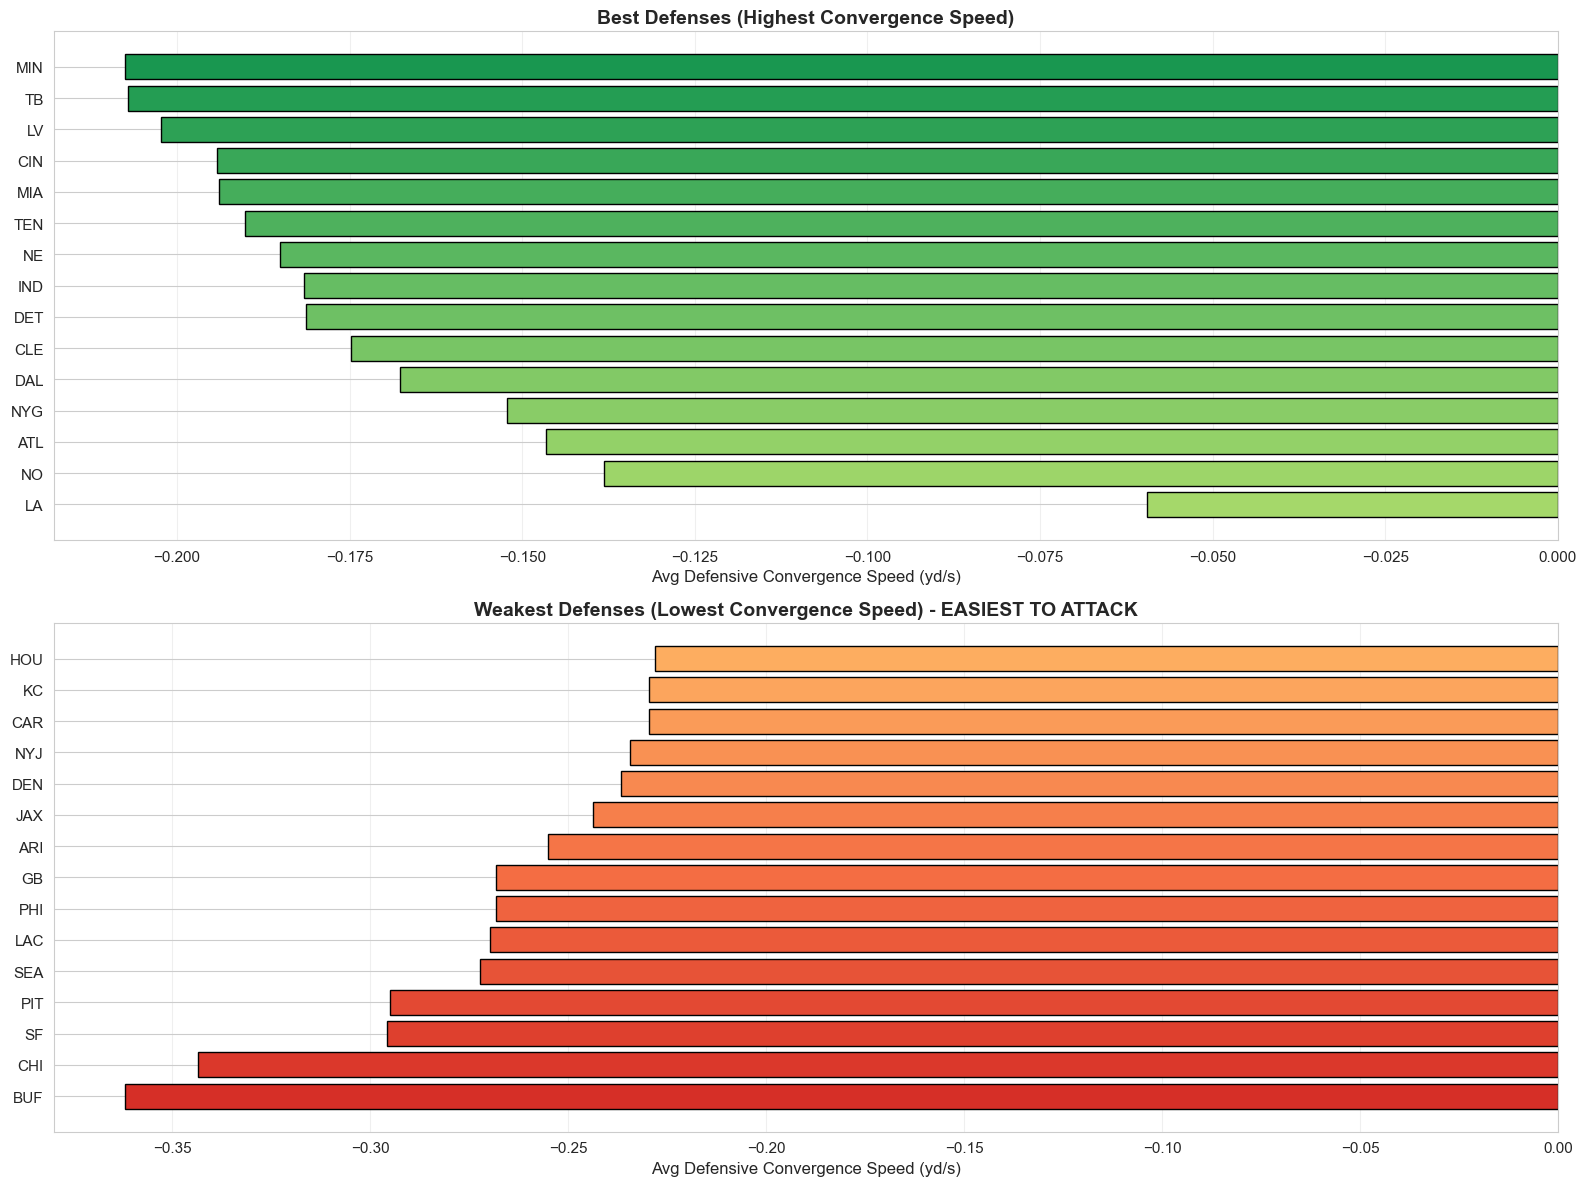

✅ Figure 1 saved!


In [9]:
# FIGURE 1: Team convergence comparison
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# Top 15 and bottom 15 teams
n_teams = min(15, len(rankings))

# Top: Best defenses (highest convergence)
ax = axes[0]
best_teams = rankings.nlargest(n_teams, 'Avg Convergence')
colors_best = plt.cm.RdYlGn(np.linspace(0.7, 0.9, n_teams))
ax.barh(range(n_teams), best_teams['Avg Convergence'].values, 
        color=colors_best, edgecolor='black')
ax.set_yticks(range(n_teams))
ax.set_yticklabels(best_teams['Team'].values)
ax.set_xlabel('Avg Defensive Convergence Speed (yd/s)', fontsize=12)
ax.set_title('Best Defenses (Highest Convergence Speed)', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3, axis='x')

# Bottom: Worst defenses (lowest convergence) - EASIEST TO ATTACK
ax = axes[1]
worst_teams = rankings.nsmallest(n_teams, 'Avg Convergence')
colors_worst = plt.cm.RdYlGn(np.linspace(0.1, 0.3, n_teams))
ax.barh(range(n_teams), worst_teams['Avg Convergence'].values, 
        color=colors_worst, edgecolor='black')
ax.set_yticks(range(n_teams))
ax.set_yticklabels(worst_teams['Team'].values)
ax.set_xlabel('Avg Defensive Convergence Speed (yd/s)', fontsize=12)
ax.set_title('Weakest Defenses (Lowest Convergence Speed) - EASIEST TO ATTACK', 
            fontsize=14, fontweight='bold')
ax.grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'team_defensive_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Figure 1 saved!")

## 9. Route-Specific Team Vulnerabilities

ROUTE VULNERABILITY MATRIX

Route Vulnerability Matrix (Avg Convergence by Team & Route):
Route  ANGLE   FLAT  HITCH  IN  SCREEN  SLANT
Team                                         
ARI   -1.335 -0.721 -0.534 NaN     NaN    NaN
ATL   -1.613    NaN    NaN NaN  -1.228 -0.660
BAL   -1.656 -0.696    NaN NaN     NaN -0.713
BUF   -1.587 -0.815    NaN NaN  -1.036    NaN
CAR   -1.458 -0.611    NaN NaN  -0.712    NaN
CHI   -1.570 -0.814    NaN NaN  -0.873    NaN
CIN   -1.661 -0.806 -0.629 NaN     NaN    NaN
CLE   -1.422 -0.607    NaN NaN  -1.108    NaN
DAL   -1.393    NaN -0.504 NaN  -0.763    NaN
DEN   -1.236 -0.675    NaN NaN  -0.881    NaN


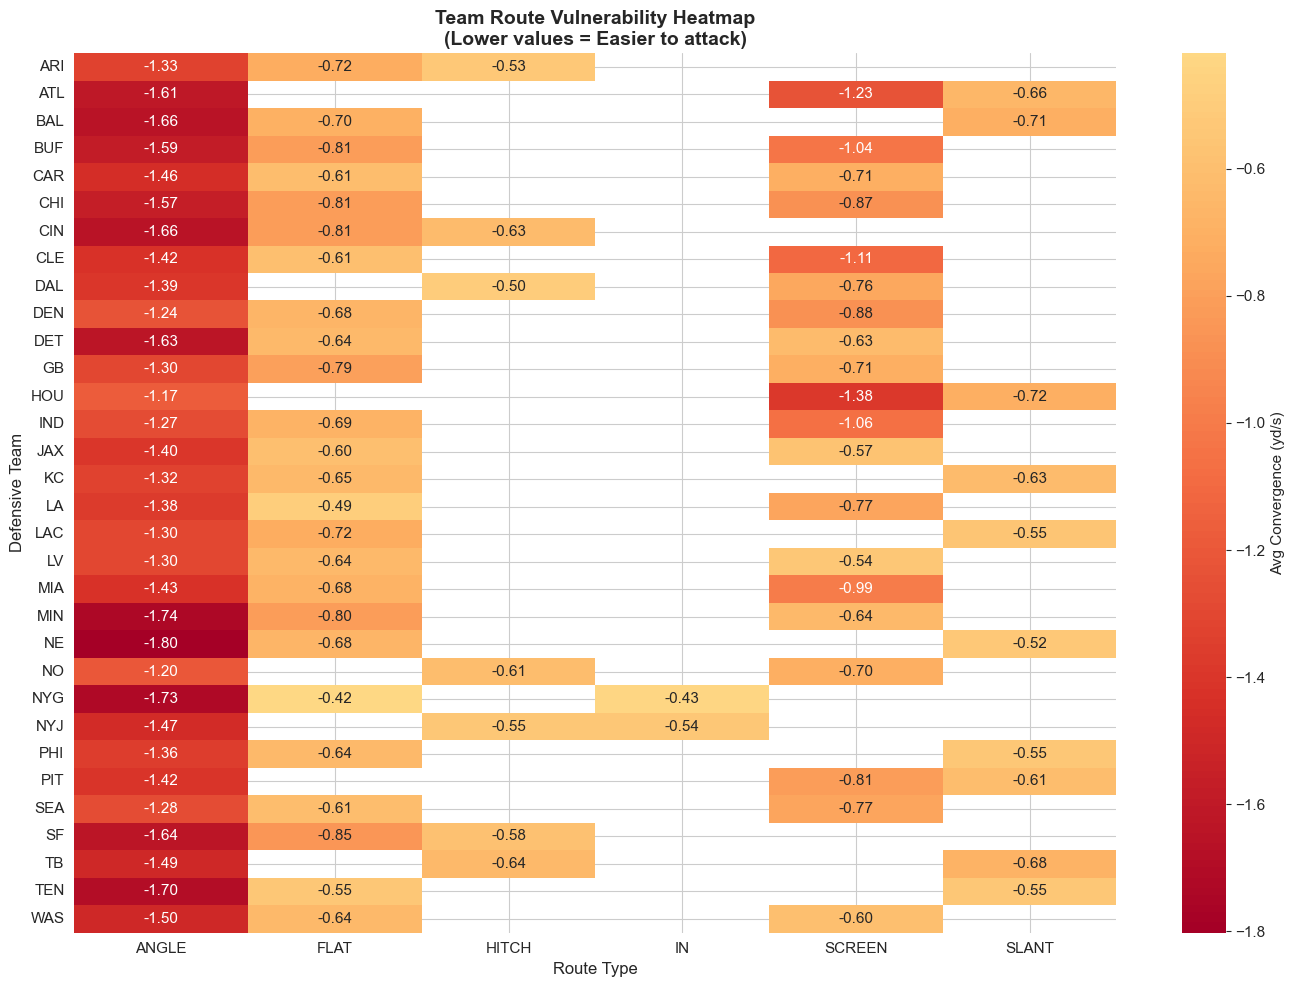

✅ Heatmap saved!


In [10]:
# Create route vulnerability matrix
print("="*80)
print("ROUTE VULNERABILITY MATRIX")
print("="*80)

# For each team, identify their worst routes
route_vulnerabilities = []

for team, report in all_reports.items():
    if 'weakest_routes' not in report:
        continue
    
    routes = report['weakest_routes']
    if 'Avg Conv' not in routes:
        continue
    
    for route, conv in list(routes['Avg Conv'].items())[:3]:  # Top 3 worst routes
        route_vulnerabilities.append({
            'Team': team,
            'Route': route,
            'Avg Convergence': conv,
            'Plays': int(routes['N'].get(route, 0))
        })

route_vuln_df = pd.DataFrame(route_vulnerabilities)

# Pivot to create matrix
if len(route_vuln_df) > 0:
    route_matrix = route_vuln_df.pivot_table(
        values='Avg Convergence',
        index='Team',
        columns='Route',
        aggfunc='mean'
    )
    
    # Save matrix
    route_matrix.to_csv(OUTPUT_DIR / 'team_route_vulnerability_matrix.csv')
    
    print("\nRoute Vulnerability Matrix (Avg Convergence by Team & Route):")
    print(route_matrix.head(10))
    
    # Visualize heatmap
    if len(route_matrix) > 0:
        fig, ax = plt.subplots(figsize=(14, 10))
        
        sns.heatmap(route_matrix, annot=True, fmt='.2f', cmap='RdYlGn', 
                   center=0, ax=ax, cbar_kws={'label': 'Avg Convergence (yd/s)'})
        
        ax.set_title('Team Route Vulnerability Heatmap\n(Lower values = Easier to attack)', 
                    fontsize=14, fontweight='bold')
        ax.set_xlabel('Route Type', fontsize=12)
        ax.set_ylabel('Defensive Team', fontsize=12)
        
        plt.tight_layout()
        plt.savefig(OUTPUT_DIR / 'route_vulnerability_heatmap.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("✅ Heatmap saved!")

## 10. Create Quick Reference Cards

In [12]:
def create_quick_reference_card(team_abbr, report, filename):
    """Create a visual quick reference card for game week"""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'{team_abbr} DEFENSE - QUICK REFERENCE CARD', 
                fontsize=16, fontweight='bold')
    
    # Top left: Key metrics
    ax = axes[0, 0]
    ax.axis('off')
    
    metrics_text = f"""
OVERALL METRICS
━━━━━━━━━━━━━━━━━━━━━━
Plays Analyzed: {report['total_plays']}
Avg Convergence: {report['avg_convergence']:.3f} yd/s
Avg Min Distance: {report['avg_min_distance']:.2f} yards
    """
    
    if 'completion_rate_against' in report:
        metrics_text += f"Completion Rate: {report['completion_rate_against']*100:.1f}%\n"
    
    ax.text(0.1, 0.5, metrics_text, fontsize=11, family='monospace',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Top right: Routes to attack
    ax = axes[0, 1]
    ax.axis('off')
    
    routes_text = "ROUTES TO ATTACK\n" + "━"*30 + "\n"
    if 'weakest_routes' in report and 'Avg Conv' in report['weakest_routes']:
        routes = report['weakest_routes']
        for i, (route, conv) in enumerate(list(routes['Avg Conv'].items())[:5], 1):
            routes_text += f"{i}. {route}: {conv:.3f} yd/s\n"
    
    ax.text(0.1, 0.5, routes_text, fontsize=11, family='monospace',
           bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
    
    # Bottom left: Players to target
    ax = axes[1, 0]
    ax.axis('off')
    
    players_text = "PLAYERS TO TARGET\n" + "━"*30 + "\n"
    if 'worst_convergers' in report and 'Avg Conv' in report['worst_convergers']:
        players = report['worst_convergers']
        has_names = 'player_name' in players
        
        for i, (player_id, conv) in enumerate(list(players['Avg Conv'].items())[:5], 1):
            position = players['Position'].get(player_id, 'UNK')
            
            if has_names:
                name = players['player_name'].get(player_id, f"#{int(player_id)}")
                players_text += f"{i}. {name} ({position}): {conv:.3f}\n"
            else:
                players_text += f"{i}. #{int(player_id)} ({position}): {conv:.3f}\n"
    
    ax.text(0.1, 0.5, players_text, fontsize=11, family='monospace',
           bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.5))
    
    # Bottom right: Coverage notes
    ax = axes[1, 1]
    ax.axis('off')
    
    coverage_text = "COVERAGE ANALYSIS\n" + "━"*30 + "\n"
    if 'coverage_stats' in report and 'Avg Conv' in report['coverage_stats']:
        coverages = report['coverage_stats']
        for coverage, conv in sorted(coverages['Avg Conv'].items(), key=lambda x: x[1])[:4]:
            coverage_text += f"• {coverage}: {conv:.3f} yd/s\n"
    
    ax.text(0.1, 0.5, coverage_text, fontsize=11, family='monospace',
           bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
    
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()

# Generate reference cards for all teams
print("="*80)
print("GENERATING QUICK REFERENCE CARDS")
print("="*80)

cards_dir = OUTPUT_DIR / 'reference_cards'
cards_dir.mkdir(exist_ok=True)

for team, report in all_reports.items():
    card_file = cards_dir / f'{team}_quick_reference.png'
    create_quick_reference_card(team, report, card_file)
    print(f"✓ Created card for {team}")

print(f"\n✅ All reference cards saved to: {cards_dir}")

GENERATING QUICK REFERENCE CARDS
✓ Created card for ARI
✓ Created card for ATL
✓ Created card for BAL
✓ Created card for BUF
✓ Created card for CAR
✓ Created card for CHI
✓ Created card for CIN
✓ Created card for CLE
✓ Created card for DAL
✓ Created card for DEN
✓ Created card for DET
✓ Created card for GB
✓ Created card for HOU
✓ Created card for IND
✓ Created card for JAX
✓ Created card for KC
✓ Created card for LA
✓ Created card for LAC
✓ Created card for LV
✓ Created card for MIA
✓ Created card for MIN
✓ Created card for NE
✓ Created card for NO
✓ Created card for NYG
✓ Created card for NYJ
✓ Created card for PHI
✓ Created card for PIT
✓ Created card for SEA
✓ Created card for SF
✓ Created card for TB
✓ Created card for TEN
✓ Created card for WAS

✅ All reference cards saved to: ..\data\processed\team_scouting\reference_cards


## 11. Summary Report

In [13]:
print("="*80)
print("TEAM SCOUTING - SUMMARY")
print("="*80)

print(f"""
SCOUTING REPORTS GENERATED:
• Total teams analyzed: {len(all_reports)}
• Total plays analyzed: {sum(r['total_plays'] for r in all_reports.values()):,}

EASIEST DEFENSES TO ATTACK (Bottom 5):
""")

for i, row in rankings.head(5).iterrows():
    print(f"  {row['Rank']}. {row['Team']}: {row['Avg Convergence']:.3f} yd/s convergence, "
          f"{row['Completion Rate']*100:.1f}% completions allowed")

print(f"""
TOUGHEST DEFENSES (Top 5):
""")

for i, row in rankings.tail(5).iterrows():
    print(f"  {row['Rank']}. {row['Team']}: {row['Avg Convergence']:.3f} yd/s convergence, "
          f"{row['Completion Rate']*100:.1f}% completions allowed")

print(f"""
FILES GENERATED:
✓ team_defensive_rankings.csv - Complete rankings
✓ team_route_vulnerability_matrix.csv - Route-specific weaknesses
✓ team_defensive_comparison.png - Visual comparison
✓ route_vulnerability_heatmap.png - Matrix visualization
✓ individual_teams/ - Detailed text reports for each team
✓ reference_cards/ - Visual quick reference cards

USAGE:
1. Check rankings to identify easiest/toughest opponents
2. Open specific team's report before game week
3. Use quick reference card for sideline/booth reference
4. Target identified routes and players during game planning

""")

print("="*80)
print("✅ TEAM SCOUTING COMPLETE!")
print("="*80)

TEAM SCOUTING - SUMMARY

SCOUTING REPORTS GENERATED:
• Total teams analyzed: 32
• Total plays analyzed: 14,108

EASIEST DEFENSES TO ATTACK (Bottom 5):

  1. BUF: -0.362 yd/s convergence, 72.4% completions allowed
  2. CHI: -0.343 yd/s convergence, 69.7% completions allowed
  3. SF: -0.296 yd/s convergence, 70.1% completions allowed
  4. PIT: -0.295 yd/s convergence, 65.3% completions allowed
  5. SEA: -0.272 yd/s convergence, 70.9% completions allowed

TOUGHEST DEFENSES (Top 5):

  28. DAL: -0.168 yd/s convergence, 63.8% completions allowed
  29. NYG: -0.152 yd/s convergence, 68.1% completions allowed
  30. ATL: -0.147 yd/s convergence, 67.5% completions allowed
  31. NO: -0.138 yd/s convergence, 64.0% completions allowed
  32. LA: -0.060 yd/s convergence, 66.4% completions allowed

FILES GENERATED:
✓ team_defensive_rankings.csv - Complete rankings
✓ team_route_vulnerability_matrix.csv - Route-specific weaknesses
✓ team_defensive_comparison.png - Visual comparison
✓ route_vulnerability